In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, train_test_split, ShuffleSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time
from itertools import product
import matplotlib.pyplot as plt
from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor
import joblib  # 모델 저장을 위한 라이브러리

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False


In [27]:
def calculate_metrics(y_true, y_pred, training_time):
	"""평가 지표 계산 함수"""
	return {
		'MAE': mean_absolute_error(y_true, y_pred),
		'MSE': mean_squared_error(y_true, y_pred),
		'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
		'R2': r2_score(y_true, y_pred),
		'RMSLE': np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred))),
		'MAPE': np.mean(np.abs((y_true - y_pred) / y_true)) * 100,
		'Training_Time': training_time
	}

### 광어

In [3]:

def train_evaluate_lgbm_multistep(data, target_col='avgPrice', exclude_features=None, steps=28, time_series=True):
	"""
	LightGBM 모델의 멀티스텝 예측 (다중 출력 모델) 학습 및 평가.

	Args:
		data (pd.DataFrame): 학습 데이터셋.
		target_col (str): 예측 대상 열 이름.
		exclude_features (list): 학습에 제외할 피처 리스트.
		steps (int): 예측할 시점 개수.
		time_series (bool): 타임 시리즈 데이터 여부.

	Returns:
		model: 학습된 멀티아웃풋 모델.
	"""
	# 날짜 열을 datetime 형식으로 변환
	data['date'] = pd.to_datetime(data['date'])

	# 다중 출력 타겟 생성 (t+1, t+2, ..., t+steps)
	for step in range(1, steps + 1):
		data[f'{target_col}+{step}'] = data[target_col].shift(-step)
	data = data.dropna()  # NaN 값 제거

	# 입력 데이터와 다중 출력 타겟 설정
	X = data.drop(['date', 'item'] + [target_col] + [f'{target_col}+{i}' for i in range(1, steps + 1)], axis=1)
	y = data[[f'{target_col}+{i}' for i in range(1, steps + 1)]]

	# 특정 피처 제외 (exclude_features 리스트 기반)
	if exclude_features:
		X = X.drop(columns=exclude_features)
    
    # LightGBM 하이퍼파라미터 설정
	lgbm_params = {
		'n_estimators': 90,
		'max_depth': 7,
		'learning_rate':  0.1,
		'num_leaves': 8,
		'min_child_samples': 6,
		'subsample': 0.9,
		'colsample_bytree': 0.9 ,
		'random_state': 1030,
		'n_jobs': -1
	}

	# 교차 검증 방식 설정 (타임 시리즈 또는 무작위 분할)
	if time_series:
		test_size = len(X) // 10
		cv = TimeSeriesSplit(n_splits=5, test_size=test_size)
	else:
		from sklearn.model_selection import ShuffleSplit
		cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1030)

	# MultiOutputRegressor로 멀티스텝 예측을 지원
	base_model = LGBMRegressor(**lgbm_params)
	multi_output_model = MultiOutputRegressor(base_model)

	# 모델 학습
	start_time = time.time()
	multi_output_model.fit(X, y)
	training_time = time.time() - start_time

	# 학습 시 사용된 피처 이름 저장
	joblib.dump(X.columns.tolist(), 'feature_names_multi.pkl')
	print("Feature names saved to 'feature_names_multi.pkl'")

	# 학습 시간 출력
	print(f"Training Time: {training_time:.2f} seconds")

	# 모델 예측
	y_pred = multi_output_model.predict(X)

	# 성능 평가 (RMSE, R2, MAE)
	rmse = np.sqrt(mean_squared_error(y, y_pred, multioutput='raw_values'))
	r2 = r2_score(y, y_pred, multioutput='variance_weighted')
	mae = mean_absolute_error(y, y_pred, multioutput='raw_values')

	print("\n** Model Performance **")
	print(f"RMSE (Per Step): {rmse}")
	print(f"R2 Score: {r2:.4f}")
	print(f"MAE (Per Step): {mae}")

	# 중요도 시각화
	feature_importances = np.mean([
		model.feature_importances_ for model in multi_output_model.estimators_
	], axis=0)
	importance_df = pd.DataFrame({
		'Feature': X.columns,
		'Importance': feature_importances
	}).sort_values(by='Importance', ascending=False)

	print("\nFeature Importances:")
	print(importance_df)

	plt.figure(figsize=(10, 6))
	plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
	plt.xlabel('Importance')
	plt.ylabel('Feature')
	plt.title('Feature Importances')
	plt.gca().invert_yaxis()  # 중요도가 높은 순으로 정렬
	plt.tight_layout()
	plt.show()


	return multi_output_model




In [ ]:
# 데이터 로드 및 모델 학습 실행
data = pd.read_csv('../../../data/features/final_oneHot/광어_price_features_notnull.csv')
exclude_features = ['m_노량진시장']
model_다중_광어 = train_evaluate_lgbm_multistep(data, target_col='avgPrice', exclude_features=exclude_features, steps=28, time_series=True)
print(model_다중_광어)

# 학습된 모델 저장
joblib.dump(model_다중_광어, 'lgbm_다중_광어.joblib')  

print("\n학습된 모델이 'lgbm_다중_광어.joblib'로 저장되었습니다.")

### 농어

In [28]:

def train_evaluate_lgbm_multistep(data, target_col='avgPrice', exclude_features=None, steps=28, time_series=True):
	"""
	LightGBM 모델의 멀티스텝 예측 (다중 출력 모델) 학습 및 평가.

	Args:
		data (pd.DataFrame): 학습 데이터셋.
		target_col (str): 예측 대상 열 이름.
		exclude_features (list): 학습에 제외할 피처 리스트.
		steps (int): 예측할 시점 개수.
		time_series (bool): 타임 시리즈 데이터 여부.

	Returns:
		model: 학습된 멀티아웃풋 모델.
	"""
	# 날짜 열을 datetime 형식으로 변환
	data['date'] = pd.to_datetime(data['date'])

	# 다중 출력 타겟 생성 (t+1, t+2, ..., t+steps)
	for step in range(1, steps + 1):
		data[f'{target_col}+{step}'] = data[target_col].shift(-step)
	data = data.dropna()  # NaN 값 제거

	# 입력 데이터와 다중 출력 타겟 설정
	X = data.drop(['date', 'item'] + [target_col] + [f'{target_col}+{i}' for i in range(1, steps + 1)], axis=1)
	y = data[[f'{target_col}+{i}' for i in range(1, steps + 1)]]

	# 특정 피처 제외 (exclude_features 리스트 기반)
	if exclude_features:
		X = X.drop(columns=exclude_features)

	# LightGBM 하이퍼파라미터 설정
	# 250127 기준 확정 
	lgbm_params = {
		'n_estimators': 100,
		'max_depth': 6,
		'learning_rate': 0.1,
		'num_leaves': 8,
		'min_child_samples': 6,
		'subsample': 0.9,
		'colsample_bytree': 0.9,
		'random_state': 1030,
		'n_jobs': -1
	}
    
	# 교차 검증 방식 설정 (타임 시리즈 또는 무작위 분할)
	if time_series:
		test_size = len(X) // 10
		cv = TimeSeriesSplit(n_splits=5, test_size=test_size)
	else:
		from sklearn.model_selection import ShuffleSplit
		cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1030)

	# MultiOutputRegressor로 멀티스텝 예측을 지원
	base_model = LGBMRegressor(**lgbm_params)
	multi_output_model = MultiOutputRegressor(base_model)

	# 모델 학습
	start_time = time.time()
	multi_output_model.fit(X, y)
	training_time = time.time() - start_time

	# 학습 시 사용된 피처 이름 저장
	joblib.dump(X.columns.tolist(), 'feature_names_multi.pkl')
	print("Feature names saved to 'feature_names_multi.pkl'")

	# 학습 시간 출력
	print(f"Training Time: {training_time:.2f} seconds")

	# 모델 예측
	y_pred = multi_output_model.predict(X)

	# 성능 평가 (RMSE, R2, MAE)
	rmse = np.sqrt(mean_squared_error(y, y_pred, multioutput='raw_values'))
	r2 = r2_score(y, y_pred, multioutput='variance_weighted')
	mae = mean_absolute_error(y, y_pred, multioutput='raw_values')

	print("\n** Model Performance **")
	print(f"RMSE (Per Step): {rmse}")
	print(f"R2 Score: {r2:.4f}")
	print(f"MAE (Per Step): {mae}")

	# 중요도 시각화
	feature_importances = np.mean([
		model.feature_importances_ for model in multi_output_model.estimators_
	], axis=0)
	importance_df = pd.DataFrame({
		'Feature': X.columns,
		'Importance': feature_importances
	}).sort_values(by='Importance', ascending=False)

	print("\nFeature Importances:")
	print(importance_df)

	plt.figure(figsize=(10, 6))
	plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
	plt.xlabel('Importance')
	plt.ylabel('Feature')
	plt.title('Feature Importances')
	plt.gca().invert_yaxis()  # 중요도가 높은 순으로 정렬
	plt.tight_layout()
	plt.show()


	return multi_output_model




Feature names saved to 'feature_names_multi.pkl'
Training Time: 3.30 seconds

** Model Performance **
RMSE (Per Step): [1566.211232   1528.93217712 1603.57122904 1486.14533366 1559.93707814
 1624.03611613 1651.58398185 1648.93443696 1397.13285237 1742.00173162
 1593.90503646 1622.79091337 1708.58639553 1603.50151199 1661.5822383
 1594.79803462 1659.95605193 1269.67146285 1786.09586839 1546.275426
 1573.08764116 1732.7394223  1628.35608452 1799.42104024 1899.60893207
 1801.78902831 1322.24232325 1749.20354409]
R2 Score: 0.8918
MAE (Per Step): [1186.52969404 1162.1417095  1212.5492617  1144.14950217 1212.10747094
 1236.94730887 1240.34645281 1229.19796758  850.51699852 1316.41980466
 1222.83167425 1242.93929956 1253.88152531 1223.14695214 1221.58159076
 1214.73392891 1227.70708414  774.19386736 1320.03530623 1153.18411335
 1206.04900268 1311.55604046 1251.89703944 1311.7164269  1419.90698043
 1329.47789015  828.12548795 1346.76884215]

Feature Importances:
             Feature  Importanc

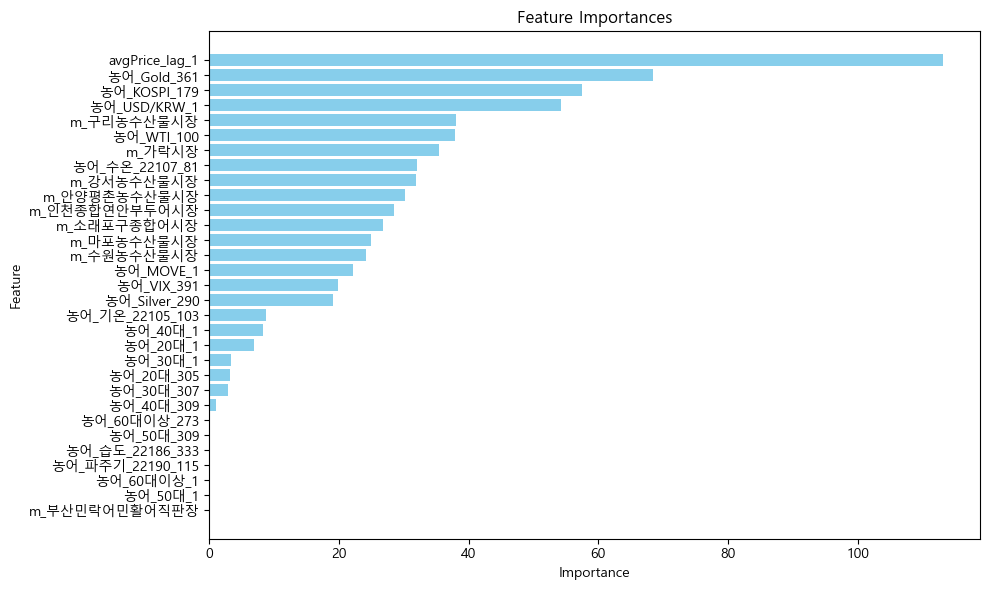

MultiOutputRegressor(estimator=LGBMRegressor(colsample_bytree=0.9, max_depth=6,
                                             min_child_samples=6, n_jobs=-1,
                                             num_leaves=8, random_state=1030,
                                             subsample=0.9))

학습된 모델이 'lgbm_다중_농어.joblib'로 저장되었습니다.


In [29]:
# 데이터 로드 및 모델 학습 실행
data = pd.read_csv('../../../data/features/final_oneHot/농어_price_features_notnull.csv')
exclude_features = ['m_노량진시장']
model_다중_농어 = train_evaluate_lgbm_multistep(data, target_col='avgPrice', exclude_features=exclude_features, steps=28, time_series=True)
print(model_다중_농어)

# 학습된 모델 저장
joblib.dump(model_다중_농어, 'lgbm_다중_농어.joblib')  

print("\n학습된 모델이 'lgbm_다중_농어.joblib'로 저장되었습니다.")

### 대게

In [9]:

def train_evaluate_lgbm_multistep(data, target_col='avgPrice', exclude_features=None, steps=28, time_series=True):
	"""
	LightGBM 모델의 멀티스텝 예측 (다중 출력 모델) 학습 및 평가.

	Args:
		data (pd.DataFrame): 학습 데이터셋.
		target_col (str): 예측 대상 열 이름.
		exclude_features (list): 학습에 제외할 피처 리스트.
		steps (int): 예측할 시점 개수.
		time_series (bool): 타임 시리즈 데이터 여부.

	Returns:
		model: 학습된 멀티아웃풋 모델.
	"""
	# 날짜 열을 datetime 형식으로 변환
	data['date'] = pd.to_datetime(data['date'])

	# 다중 출력 타겟 생성 (t+1, t+2, ..., t+steps)
	for step in range(1, steps + 1):
		data[f'{target_col}+{step}'] = data[target_col].shift(-step)
	data = data.dropna()  # NaN 값 제거

	# 입력 데이터와 다중 출력 타겟 설정
	X = data.drop(['date', 'item'] + [target_col] + [f'{target_col}+{i}' for i in range(1, steps + 1)], axis=1)
	y = data[[f'{target_col}+{i}' for i in range(1, steps + 1)]]

	# 특정 피처 제외 (exclude_features 리스트 기반)
	if exclude_features:
		X = X.drop(columns=exclude_features)

	# LightGBM 하이퍼파라미터 설정
	# 250127 기준 확정 
	lgbm_params = {
		'n_estimators': 90,
		'max_depth': 7,
		'learning_rate': 0.1,
		'num_leaves': 8,
		'min_child_samples': 6,
		'subsample': 0.9,
		'colsample_bytree': 0.9,
		'random_state': 1030,
		'n_jobs': -1
	}
    
	# 교차 검증 방식 설정 (타임 시리즈 또는 무작위 분할)
	if time_series:
		test_size = len(X) // 10
		cv = TimeSeriesSplit(n_splits=5, test_size=test_size)
	else:
		from sklearn.model_selection import ShuffleSplit
		cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1030)

	# MultiOutputRegressor로 멀티스텝 예측을 지원
	base_model = LGBMRegressor(**lgbm_params)
	multi_output_model = MultiOutputRegressor(base_model)

	# 모델 학습
	start_time = time.time()
	multi_output_model.fit(X, y)
	training_time = time.time() - start_time

	# 학습 시 사용된 피처 이름 저장
	joblib.dump(X.columns.tolist(), 'feature_names_multi.pkl')
	print("Feature names saved to 'feature_names_multi.pkl'")

	# 학습 시간 출력
	print(f"Training Time: {training_time:.2f} seconds")

	# 모델 예측
	y_pred = multi_output_model.predict(X)

	# 성능 평가 (RMSE, R2, MAE)
	rmse = np.sqrt(mean_squared_error(y, y_pred, multioutput='raw_values'))
	r2 = r2_score(y, y_pred, multioutput='variance_weighted')
	mae = mean_absolute_error(y, y_pred, multioutput='raw_values')

	print("\n** Model Performance **")
	print(f"RMSE (Per Step): {rmse}")
	print(f"R2 Score: {r2:.4f}")
	print(f"MAE (Per Step): {mae}")

	# 중요도 시각화
	feature_importances = np.mean([
		model.feature_importances_ for model in multi_output_model.estimators_
	], axis=0)
	importance_df = pd.DataFrame({
		'Feature': X.columns,
		'Importance': feature_importances
	}).sort_values(by='Importance', ascending=False)

	print("\nFeature Importances:")
	print(importance_df)

	plt.figure(figsize=(10, 6))
	plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
	plt.xlabel('Importance')
	plt.ylabel('Feature')
	plt.title('Feature Importances')
	plt.gca().invert_yaxis()  # 중요도가 높은 순으로 정렬
	plt.tight_layout()
	plt.show()


	return multi_output_model




In [ ]:
# 데이터 로드 및 모델 학습 실행
data = pd.read_csv('../../../data/features/final_oneHot/대게_price_features_notnull.csv')
exclude_features = ['m_노량진시장']
model_다중_대게 = train_evaluate_lgbm_multistep(data, target_col='avgPrice', exclude_features=exclude_features, steps=28, time_series=True)
print(model_다중_대게)

# 학습된 모델 저장
joblib.dump(model_다중_대게, 'lgbm_다중_대게.joblib')  

print("\n학습된 모델이 'lgbm_다중_대게.joblib'로 저장되었습니다.")

### 방어

In [11]:

def train_evaluate_lgbm_multistep(data, target_col='avgPrice', exclude_features=None, steps=28, time_series=True):
	"""
	LightGBM 모델의 멀티스텝 예측 (다중 출력 모델) 학습 및 평가.

	Args:
		data (pd.DataFrame): 학습 데이터셋.
		target_col (str): 예측 대상 열 이름.
		exclude_features (list): 학습에 제외할 피처 리스트.
		steps (int): 예측할 시점 개수.
		time_series (bool): 타임 시리즈 데이터 여부.

	Returns:
		model: 학습된 멀티아웃풋 모델.
	"""
	# 날짜 열을 datetime 형식으로 변환
	data['date'] = pd.to_datetime(data['date'])

	# 다중 출력 타겟 생성 (t+1, t+2, ..., t+steps)
	for step in range(1, steps + 1):
		data[f'{target_col}+{step}'] = data[target_col].shift(-step)
	data = data.dropna()  # NaN 값 제거

	# 입력 데이터와 다중 출력 타겟 설정
	X = data.drop(['date', 'item'] + [target_col] + [f'{target_col}+{i}' for i in range(1, steps + 1)], axis=1)
	y = data[[f'{target_col}+{i}' for i in range(1, steps + 1)]]

	# 특정 피처 제외 (exclude_features 리스트 기반)
	if exclude_features:
		X = X.drop(columns=exclude_features)

	# LightGBM 하이퍼파라미터 설정
	# 250127 기준 확정 
	lgbm_params = {
		'n_estimators': 45,
		'max_depth': 2,
		'learning_rate': 0.11,
		'num_leaves': 4,
		'min_child_samples': 7,
		'subsample': 0.9,
		'colsample_bytree': 0.9,
		'random_state': 1030,
		'n_jobs': -1
	}
    
	# 교차 검증 방식 설정 (타임 시리즈 또는 무작위 분할)
	if time_series:
		test_size = len(X) // 10
		cv = TimeSeriesSplit(n_splits=5, test_size=test_size)
	else:
		from sklearn.model_selection import ShuffleSplit
		cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1030)

	# MultiOutputRegressor로 멀티스텝 예측을 지원
	base_model = LGBMRegressor(**lgbm_params)
	multi_output_model = MultiOutputRegressor(base_model)

	# 모델 학습
	start_time = time.time()
	multi_output_model.fit(X, y)
	training_time = time.time() - start_time

	# 학습 시 사용된 피처 이름 저장
	joblib.dump(X.columns.tolist(), 'feature_names_multi.pkl')
	print("Feature names saved to 'feature_names_multi.pkl'")

	# 학습 시간 출력
	print(f"Training Time: {training_time:.2f} seconds")

	# 모델 예측
	y_pred = multi_output_model.predict(X)

	# 성능 평가 (RMSE, R2, MAE)
	rmse = np.sqrt(mean_squared_error(y, y_pred, multioutput='raw_values'))
	r2 = r2_score(y, y_pred, multioutput='variance_weighted')
	mae = mean_absolute_error(y, y_pred, multioutput='raw_values')

	print("\n** Model Performance **")
	print(f"RMSE (Per Step): {rmse}")
	print(f"R2 Score: {r2:.4f}")
	print(f"MAE (Per Step): {mae}")

	# 중요도 시각화
	feature_importances = np.mean([
		model.feature_importances_ for model in multi_output_model.estimators_
	], axis=0)
	importance_df = pd.DataFrame({
		'Feature': X.columns,
		'Importance': feature_importances
	}).sort_values(by='Importance', ascending=False)

	print("\nFeature Importances:")
	print(importance_df)

	plt.figure(figsize=(10, 6))
	plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
	plt.xlabel('Importance')
	plt.ylabel('Feature')
	plt.title('Feature Importances')
	plt.gca().invert_yaxis()  # 중요도가 높은 순으로 정렬
	plt.tight_layout()
	plt.show()


	return multi_output_model




In [ ]:
# 데이터 로드 및 모델 학습 실행
data = pd.read_csv('../../../data/features/final_oneHot/방어_price_features_notnull.csv')
exclude_features = [
        '방어_60대이상_1',
        '방어_50대_256',
  '방어_파주기_22105_191'    
	
]
model_다중_방어 = train_evaluate_lgbm_multistep(data, target_col='avgPrice', exclude_features=exclude_features, steps=28, time_series=True)
print(model_다중_방어)

# 학습된 모델 저장
joblib.dump(model_다중_방어, 'lgbm_다중_방어.joblib')  

print("\n학습된 모델이 'lgbm_다중_방어.joblib'로 저장되었습니다.")

### 연어 노르웨이 제외 

In [ ]:

def train_evaluate_lgbm_multistep(data, target_col='avgPrice', exclude_features=None, steps=28, time_series=True):
	"""
	LightGBM 모델의 멀티스텝 예측 (다중 출력 모델) 학습 및 평가.

	Args:
		data (pd.DataFrame): 학습 데이터셋.
		target_col (str): 예측 대상 열 이름.
		exclude_features (list): 학습에 제외할 피처 리스트.
		steps (int): 예측할 시점 개수.
		time_series (bool): 타임 시리즈 데이터 여부.

	Returns:
		model: 학습된 멀티아웃풋 모델.
	"""
	# 날짜 열을 datetime 형식으로 변환
	data['date'] = pd.to_datetime(data['date'])

	# 다중 출력 타겟 생성 (t+1, t+2, ..., t+steps)
	for step in range(1, steps + 1):
		data[f'{target_col}+{step}'] = data[target_col].shift(-step)
	data = data.dropna()  # NaN 값 제거

	# 입력 데이터와 다중 출력 타겟 설정
	X = data.drop(['date', 'item'] + [target_col] + [f'{target_col}+{i}' for i in range(1, steps + 1)], axis=1)
	y = data[[f'{target_col}+{i}' for i in range(1, steps + 1)]]

	# 특정 피처 제외 (exclude_features 리스트 기반)
	if exclude_features:
		X = X.drop(columns=exclude_features)

	# LightGBM 하이퍼파라미터 설정
	# 250127 기준 확정 
	lgbm_params = {
		'n_estimators': 60,
		'max_depth': 7,
		'learning_rate': 0.09,
		'num_leaves': 8,
		'min_child_samples': 6,
		'subsample': 0.9,
		'colsample_bytree': 0.9,
		'random_state': 1030,
		'n_jobs': -1
	}
    
	# 교차 검증 방식 설정 (타임 시리즈 또는 무작위 분할)
	if time_series:
		test_size = len(X) // 10
		cv = TimeSeriesSplit(n_splits=5, test_size=test_size)
	else:
		from sklearn.model_selection import ShuffleSplit
		cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1030)

	# MultiOutputRegressor로 멀티스텝 예측을 지원
	base_model = LGBMRegressor(**lgbm_params)
	multi_output_model = MultiOutputRegressor(base_model)

	# 모델 학습
	start_time = time.time()
	multi_output_model.fit(X, y)
	training_time = time.time() - start_time

	# 학습 시 사용된 피처 이름 저장
	joblib.dump(X.columns.tolist(), 'feature_names_multi.pkl')
	print("Feature names saved to 'feature_names_multi.pkl'")

	# 학습 시간 출력
	print(f"Training Time: {training_time:.2f} seconds")

	# 모델 예측
	y_pred = multi_output_model.predict(X)

	# 성능 평가 (RMSE, R2, MAE)
	rmse = np.sqrt(mean_squared_error(y, y_pred, multioutput='raw_values'))
	r2 = r2_score(y, y_pred, multioutput='variance_weighted')
	mae = mean_absolute_error(y, y_pred, multioutput='raw_values')

	print("\n** Model Performance **")
	print(f"RMSE (Per Step): {rmse}")
	print(f"R2 Score: {r2:.4f}")
	print(f"MAE (Per Step): {mae}")

	# 중요도 시각화
	feature_importances = np.mean([
		model.feature_importances_ for model in multi_output_model.estimators_
	], axis=0)
	importance_df = pd.DataFrame({
		'Feature': X.columns,
		'Importance': feature_importances
	}).sort_values(by='Importance', ascending=False)

	print("\nFeature Importances:")
	print(importance_df)

	plt.figure(figsize=(10, 6))
	plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
	plt.xlabel('Importance')
	plt.ylabel('Feature')
	plt.title('Feature Importances')
	plt.gca().invert_yaxis()  # 중요도가 높은 순으로 정렬
	plt.tight_layout()
	plt.show()


	return multi_output_model




In [ ]:
# 데이터 로드 및 모델 학습 실행
data = pd.read_csv('../../../data/features/final_oneHot/연어_price_features_notnull_노르웨이제외.csv')
exclude_features = [
        '연어_40대_21',
     '연어_60대이상_397',
        '연어_50대_15',
   '연어_파주기_22190_9',

       '연어_60대이상_1',
         '연어_50대_1',
         '연어_40대_1',
         '연어_30대_1',
        '연어_30대_15'


]
model_다중_연어 = train_evaluate_lgbm_multistep(data, target_col='avgPrice', exclude_features=exclude_features, steps=28, time_series=True)
print(model_다중_연어)

# 학습된 모델 저장
joblib.dump(model_다중_연어, 'lgbm_다중_연어.joblib')  

print("\n학습된 모델이 'lgbm_다중_연어.joblib'로 저장되었습니다.")

### 우럭

In [18]:

def train_evaluate_lgbm_multistep(data, target_col='avgPrice', exclude_features=None, steps=28, time_series=True):
	"""
	LightGBM 모델의 멀티스텝 예측 (다중 출력 모델) 학습 및 평가.

	Args:
		data (pd.DataFrame): 학습 데이터셋.
		target_col (str): 예측 대상 열 이름.
		exclude_features (list): 학습에 제외할 피처 리스트.
		steps (int): 예측할 시점 개수.
		time_series (bool): 타임 시리즈 데이터 여부.

	Returns:
		model: 학습된 멀티아웃풋 모델.
	"""
	# 날짜 열을 datetime 형식으로 변환
	data['date'] = pd.to_datetime(data['date'])

	# 다중 출력 타겟 생성 (t+1, t+2, ..., t+steps)
	for step in range(1, steps + 1):
		data[f'{target_col}+{step}'] = data[target_col].shift(-step)
	data = data.dropna()  # NaN 값 제거

	# 입력 데이터와 다중 출력 타겟 설정
	X = data.drop(['date', 'item'] + [target_col] + [f'{target_col}+{i}' for i in range(1, steps + 1)], axis=1)
	y = data[[f'{target_col}+{i}' for i in range(1, steps + 1)]]

	# 특정 피처 제외 (exclude_features 리스트 기반)
	if exclude_features:
		X = X.drop(columns=exclude_features)

	# LightGBM 하이퍼파라미터 설정
	# 250127 기준 확정 
	lgbm_params = {
        'n_estimators': 105 ,
        'max_depth': 3,
        'learning_rate': 0.1,
        'num_leaves': 4,
        'min_child_samples': 8,
        'subsample': 0.9,
        'colsample_bytree': 0.9,
        'random_state': 1030,
        'n_jobs': -1
	}
    
	# 교차 검증 방식 설정 (타임 시리즈 또는 무작위 분할)
	if time_series:
		test_size = len(X) // 10
		cv = TimeSeriesSplit(n_splits=5, test_size=test_size)
	else:
		from sklearn.model_selection import ShuffleSplit
		cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1030)

	# MultiOutputRegressor로 멀티스텝 예측을 지원
	base_model = LGBMRegressor(**lgbm_params)
	multi_output_model = MultiOutputRegressor(base_model)

	# 모델 학습
	start_time = time.time()
	multi_output_model.fit(X, y)
	training_time = time.time() - start_time

	# 학습 시 사용된 피처 이름 저장
	joblib.dump(X.columns.tolist(), 'feature_names_multi.pkl')
	print("Feature names saved to 'feature_names_multi.pkl'")

	# 학습 시간 출력
	print(f"Training Time: {training_time:.2f} seconds")

	# 모델 예측
	y_pred = multi_output_model.predict(X)

	# 성능 평가 (RMSE, R2, MAE)
	rmse = np.sqrt(mean_squared_error(y, y_pred, multioutput='raw_values'))
	r2 = r2_score(y, y_pred, multioutput='variance_weighted')
	mae = mean_absolute_error(y, y_pred, multioutput='raw_values')

	print("\n** Model Performance **")
	print(f"RMSE (Per Step): {rmse}")
	print(f"R2 Score: {r2:.4f}")
	print(f"MAE (Per Step): {mae}")

	# 중요도 시각화
	feature_importances = np.mean([
		model.feature_importances_ for model in multi_output_model.estimators_
	], axis=0)
	importance_df = pd.DataFrame({
		'Feature': X.columns,
		'Importance': feature_importances
	}).sort_values(by='Importance', ascending=False)

	print("\nFeature Importances:")
	print(importance_df)

	plt.figure(figsize=(10, 6))
	plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
	plt.xlabel('Importance')
	plt.ylabel('Feature')
	plt.title('Feature Importances')
	plt.gca().invert_yaxis()  # 중요도가 높은 순으로 정렬
	plt.tight_layout()
	plt.show()


	return multi_output_model




In [ ]:
# 데이터 로드 및 모델 학습 실행
data = pd.read_csv('../../../data/features/final_oneHot/우럭_price_features_notnull.csv')
exclude_features = []
model_다중_우럭 = train_evaluate_lgbm_multistep(data, target_col='avgPrice', exclude_features=exclude_features, steps=28, time_series=True)
print(model_다중_우럭)

# 학습된 모델 저장
joblib.dump(model_다중_우럭, 'lgbm_다중_우럭.joblib')  

print("\n학습된 모델이 'lgbm_다중_우럭.joblib'로 저장되었습니다.")

### 참돔


In [22]:

def train_evaluate_lgbm_multistep(data, target_col='avgPrice', exclude_features=None, steps=28, time_series=True):
	"""
	LightGBM 모델의 멀티스텝 예측 (다중 출력 모델) 학습 및 평가.

	Args:
		data (pd.DataFrame): 학습 데이터셋.
		target_col (str): 예측 대상 열 이름.
		exclude_features (list): 학습에 제외할 피처 리스트.
		steps (int): 예측할 시점 개수.
		time_series (bool): 타임 시리즈 데이터 여부.

	Returns:
		model: 학습된 멀티아웃풋 모델.
	"""
	# 날짜 열을 datetime 형식으로 변환
	data['date'] = pd.to_datetime(data['date'])

	# 다중 출력 타겟 생성 (t+1, t+2, ..., t+steps)
	for step in range(1, steps + 1):
		data[f'{target_col}+{step}'] = data[target_col].shift(-step)
	data = data.dropna()  # NaN 값 제거

	# 입력 데이터와 다중 출력 타겟 설정
	X = data.drop(['date', 'item'] + [target_col] + [f'{target_col}+{i}' for i in range(1, steps + 1)], axis=1)
	y = data[[f'{target_col}+{i}' for i in range(1, steps + 1)]]

	# 특정 피처 제외 (exclude_features 리스트 기반)
	if exclude_features:
		X = X.drop(columns=exclude_features)

	# LightGBM 하이퍼파라미터 설정
	# 250127 기준 확정 
	lgbm_params = {
		'n_estimators': 90,
		'max_depth': 7,
		'learning_rate': 0.1,
		'num_leaves': 8,
		'min_child_samples': 6,
		'subsample': 0.9,
		'colsample_bytree': 0.9,
		'random_state': 1030,
		'n_jobs': -1
	}
    
	# 교차 검증 방식 설정 (타임 시리즈 또는 무작위 분할)
	if time_series:
		test_size = len(X) // 10
		cv = TimeSeriesSplit(n_splits=5, test_size=test_size)
	else:
		from sklearn.model_selection import ShuffleSplit
		cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1030)

	# MultiOutputRegressor로 멀티스텝 예측을 지원
	base_model = LGBMRegressor(**lgbm_params)
	multi_output_model = MultiOutputRegressor(base_model)

	# 모델 학습
	start_time = time.time()
	multi_output_model.fit(X, y)
	training_time = time.time() - start_time

	# 학습 시 사용된 피처 이름 저장
	joblib.dump(X.columns.tolist(), 'feature_names_multi.pkl')
	print("Feature names saved to 'feature_names_multi.pkl'")

	# 학습 시간 출력
	print(f"Training Time: {training_time:.2f} seconds")

	# 모델 예측
	y_pred = multi_output_model.predict(X)

	# 성능 평가 (RMSE, R2, MAE)
	rmse = np.sqrt(mean_squared_error(y, y_pred, multioutput='raw_values'))
	r2 = r2_score(y, y_pred, multioutput='variance_weighted')
	mae = mean_absolute_error(y, y_pred, multioutput='raw_values')

	print("\n** Model Performance **")
	print(f"RMSE (Per Step): {rmse}")
	print(f"R2 Score: {r2:.4f}")
	print(f"MAE (Per Step): {mae}")

	# 중요도 시각화
	feature_importances = np.mean([
		model.feature_importances_ for model in multi_output_model.estimators_
	], axis=0)
	importance_df = pd.DataFrame({
		'Feature': X.columns,
		'Importance': feature_importances
	}).sort_values(by='Importance', ascending=False)

	print("\nFeature Importances:")
	print(importance_df)

	plt.figure(figsize=(10, 6))
	plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
	plt.xlabel('Importance')
	plt.ylabel('Feature')
	plt.title('Feature Importances')
	plt.gca().invert_yaxis()  # 중요도가 높은 순으로 정렬
	plt.tight_layout()
	plt.show()


	return multi_output_model




In [ ]:
# 데이터 로드 및 모델 학습 실행
data = pd.read_csv('../../../data/features/final_oneHot/참돔_price_features_notnull.csv')
exclude_features = []
model_다중_참돔 = train_evaluate_lgbm_multistep(data, target_col='avgPrice', exclude_features=exclude_features, steps=28, time_series=True)
print(model_다중_참돔)

# 학습된 모델 저장
joblib.dump(model_다중_참돔, 'lgbm_다중_참돔.joblib')  

print("\n학습된 모델이 'lgbm_다중_참돔.joblib'로 저장되었습니다.")

### 가격 예측 

In [ ]:
# 저장된 모델 로드
loaded_model = joblib.load('lgbm_다중_광어.joblib')
print("모델이 성공적으로 로드되었습니다.")